In [145]:
import pandas as pd 
import numpy as np 
from scipy import stats
from data_processing import *
from os import listdir
from os.path import isfile, join
import seaborn as sns 
import matplotlib.pyplot as plt




from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline 
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble  import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

# 3-way hold out method for hyperparameter tuning  
# (train / validation / test ) with 5-fold CV

In [49]:
x , y , num , cat = data_prep()

xtrain , xtest , ytrain , ytest = train_test_split(x , y , test_size = 0.25 , random_state = 10 )

classifiers = [
        ('KNN' , KNeighborsClassifier() , {
                                            'KNN__algorithm':('auto','ball_tree', 'kd_tree', 'brute'),
                                            'KNN__n_neighbors' : stats.randint(4 ,40),
                                            'KNN__p' : stats.randint(1 ,5),
                                            'KNN__weights' : ('uniform' , 'distance')
            }),
        ('ETclf' , ExtraTreesClassifier() , {
                            'ETclf__n_estimators': stats.randint(10 ,500),
                            'ETclf__criterion' :('gini' , 'entropy'), 
                            'ETclf__max_depth': stats.randint(10 ,50), 
                            'ETclf__max_features': ('sqrt' , 'log2', 'auto') , 
                                            }), 
        ('SGD' , SGDClassifier() , {
                    'SGD__loss' : ('hinge' , 'log'),
                    'SGD__penalty' : ('l1' , 'l2' , 'elasticnet'),
                    'SGD__alpha' : stats.uniform(loc = 0 , scale = 0.5)
            } )
]


pipe = Pipeline(steps=[

    ('handle_MV' , Impute_MV()),

    ('union' , FeatureUnion([
        ('numerical' , Pipeline(steps = [
            ('extract' , ColumnExtractor(num)),
            ('scale' , StandardScaler())
            ])),
        ('categorical' , Pipeline(steps = [
            ('extract' , ColumnExtractor(cat)),
            ('one_hot' , One_Hot())
            ]))


        ]))


    ])

In [6]:
onlyfiles = [f for f in listdir('data') if isfile(join('data', f))]

for name , clf , params in classifiers : 

    url = f'data/{name}_model_selection_algo.csv'
    if url[5:] not in onlyfiles : 
        pipe.steps.append((name , clf ))

        cv = StratifiedKFold(5)
        grid = RandomizedSearchCV(pipe , params , cv = cv , n_jobs = -1 , scoring = 'accuracy' )
        grid.fit(xtrain , ytrain)
        means = grid.cv_results_['mean_test_score']
        stds = grid.cv_results_['std_test_score']
        params = grid.cv_results_['params']
        df = pd.DataFrame({
                'means' : means,
                'stds' : stds,
                'params' : params
        })

        df.to_csv(url)
        pipe.steps = pipe.steps[:-1]
    else : 
        continue

In [110]:
ETclf = pd.read_csv('data/ETclf_model_selection_algo.csv').sort_values(by='means' , ascending = False)
SGD =  pd.read_csv('data/SGD_model_selection_algo.csv').sort_values(by='means' , ascending = False)
KNN = pd.read_csv('data/KNN_model_selection_algo.csv').sort_values(by='means' , ascending = False)
best_models = {}

In [114]:
ET = ExtraTreesClassifier()
cv = StratifiedKFold(5)
params = {}
for k in eval(ETclf.iloc[0 , -1]).keys() : 
    params[k[7:]] = eval(ETclf.iloc[0 , -1])[k]
ET.set_params(**params)
ET.fit(pipe.fit_transform(xtrain) , ytrain)
pred = ET.predict(pipe.fit_transform(xtest))
print(classification_report(pred , ytest))


score = cross_val_score(ET ,pipe.fit_transform(x) , y , cv = cv , scoring = 'accuracy' )
best_models['ETclf'] = score



              precision    recall  f1-score   support

           A       0.44      0.42      0.43       541
           B       0.26      0.38      0.31       320
           C       0.61      0.56      0.58       516
           D       0.71      0.64      0.67       640

    accuracy                           0.52      2017
   macro avg       0.51      0.50      0.50      2017
weighted avg       0.54      0.52      0.53      2017



In [115]:
knn = KNeighborsClassifier()
cv = StratifiedKFold(5)
params = {}
for k in eval(KNN.iloc[0 , -1]).keys() : 
    params[k[5:]] = eval(KNN.iloc[0 , -1])[k]
knn.set_params(**params)
knn.fit(pipe.fit_transform(xtrain) , ytrain)
pred = knn.predict(pipe.fit_transform(xtest))
print(classification_report(pred , ytest))


score = cross_val_score(knn ,pipe.fit_transform(x) , y , cv = cv , scoring = 'accuracy' )
best_models['KNN'] = score

              precision    recall  f1-score   support

           A       0.43      0.44      0.43       493
           B       0.34      0.39      0.36       395
           C       0.61      0.56      0.58       523
           D       0.68      0.65      0.67       606

    accuracy                           0.52      2017
   macro avg       0.51      0.51      0.51      2017
weighted avg       0.53      0.52      0.53      2017



In [116]:
sgd = SGDClassifier()
cv = StratifiedKFold(5)
params = {}
for k in eval(SGD.iloc[0 , -1]).keys() : 
    params[k[5:]] = eval(SGD.iloc[0 , -1])[k]
sgd.set_params(**params)
sgd.fit(pipe.fit_transform(xtrain) , ytrain)
pred = sgd.predict(pipe.fit_transform(xtest))
print(classification_report(pred , ytest))

score = cross_val_score(sgd ,pipe.fit_transform(x) , y , cv = cv , scoring = 'accuracy' )
best_models['SGD'] = score

              precision    recall  f1-score   support

           A       0.46      0.44      0.45       537
           B       0.09      0.40      0.15       105
           C       0.75      0.47      0.58       763
           D       0.67      0.63      0.65       612

    accuracy                           0.51      2017
   macro avg       0.49      0.48      0.46      2017
weighted avg       0.62      0.51      0.54      2017



In [117]:
best_params_ = {'max_depth': 11, 'max_features': 'log2', 'n_estimators': 406}
RF = RandomForestClassifier().set_params(**best_params_)
RF.fit(pipe.fit_transform(xtrain) , ytrain)
pred = RF.predict(pipe.fit_transform(xtest))
print(classification_report(pred , ytest))


score = cross_val_score(RF ,pipe.fit_transform(x) , y , cv = cv , scoring = 'accuracy' )
best_models['RFclf'] = score

              precision    recall  f1-score   support

           A       0.44      0.45      0.45       497
           B       0.29      0.39      0.33       342
           C       0.60      0.56      0.58       514
           D       0.73      0.63      0.68       664

    accuracy                           0.53      2017
   macro avg       0.52      0.51      0.51      2017
weighted avg       0.55      0.53      0.54      2017



### Interpretation : 
it seems that all models selected have the same predictive pattern , we can see that the precision percentage are higher for class C and D which mean that when the model predict (C / D) it is more likely to be actually (C / D) , same thing from recall when the classes are actually (C / d) it is more likely that the models will correctly predict those classes .

on the other side we see less recall / precision for B which mean that the models cannot predict that class well  , but for class A it is around 50 % for recall/precision 

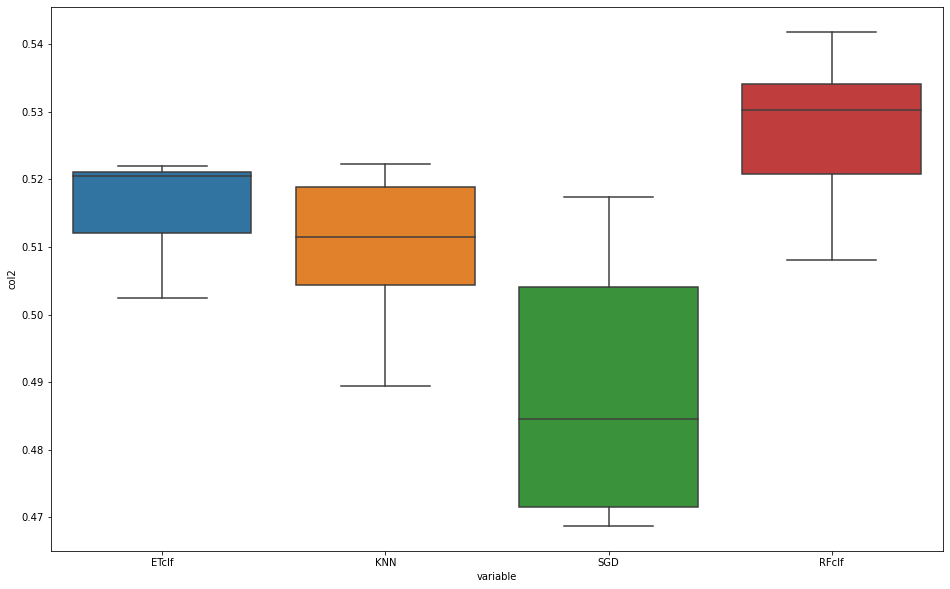

In [147]:
fig , ax = plt.subplots(1,1 , figsize = (16 , 10))

models =pd.DataFrame(best_models)
col = models.columns
df = models.melt( value_vars = col , value_name = 'col2' )
sns.boxplot(df.variable , df.col2 , ax = ax )

### Interpretation :

this plot is showing a box plot of the accuracies of 5-fold CV for each model , we can see that there is no much difference between the models , the Random forest classifier seems to perform better than the others  while on the other side the SGD model seems to have high variance , which mean small fluctuation of the model result in big shift of the accuracy 'overfitting'. to see if there is a significant difference we need to preform the F-test between the models  .

# Comparing models 

In [93]:
y_model_1 = sgd.predict(pipe.fit_transform(xtest))
y_model_2 = ET.predict(pipe.fit_transform(xtest))
y_model_3 = RF.predict(pipe.fit_transform(xtest))
y_model_4 = knn.predict(pipe.fit_transform(xtest))

In [109]:
from mlxtend.evaluate import ftest
f, p_value = ftest(np.asarray(ytest), 
                   y_model_1, 
                   y_model_2, 
                   y_model_3,
                   y_model_4)

print('F: %.3f' % f)
print('p-value: %.3f' % p_value)

F: 0.235
p-value: 0.791


the p-value is highe than threshold $\alpha = 0.05$ which mean we failed to reject the null hypothesis , meaning that there is no different between the models , now the other step would be taking account the variance , in this case we will go from comparing models to comparing algorithms 

# Comparing algorithms using 5x2CV F-test 

In [176]:
from itertools import product
from mlxtend.evaluate import combined_ftest_5x2cv

for i , j in product(*[[ET , knn , RF , sgd] ,[ET , knn , RF , sgd]]):
    if i!=j :
        
        f, p = combined_ftest_5x2cv(i,
                                    j,
                                    X=pipe.fit_transform(xtrain),
                                    y=np.asarray(ytrain), 
                                   scoring='accuracy')
        
        print(f'{str(i)[:5]} vs {str(j)[:5]}')
        print('F statistic: %.3f' % f)
        print('p value: %.3f' % p)
        print('=====================\n')


Extra vs KNeig
F statistic: 0.585
p value: 0.780

Extra vs Rando
F statistic: 7.401
p value: 0.020

Extra vs SGDCl
F statistic: 4.220
p value: 0.063

KNeig vs Extra
F statistic: 0.609
p value: 0.764

KNeig vs Rando
F statistic: 3.127
p value: 0.110

KNeig vs SGDCl
F statistic: 3.124
p value: 0.110

Rando vs Extra
F statistic: 3.544
p value: 0.088

Rando vs KNeig
F statistic: 3.616
p value: 0.084

Rando vs SGDCl
F statistic: 7.086
p value: 0.022

SGDCl vs Extra
F statistic: 2.650
p value: 0.147

SGDCl vs KNeig
F statistic: 16.089
p value: 0.003

SGDCl vs Rando
F statistic: 16.619
p value: 0.003



### Interpretation :

the difference occure between the sgd classifier and ET and RF which mean the high variance of sgd will eliminate that choice and leaves us with just RF and ET 

In [187]:
from sklearn.metrics import confusion_matrix
from statsmodels.stats.proportion import proportion_confint
RF = RandomForestClassifier().set_params(**best_params_)
RF.fit(pipe.fit_transform(xtrain) , ytrain)
pred = RF.predict(pipe.fit_transform(xtest))

cm = confusion_matrix(ytest , pred)
num_acc = np.trace(cm)
lower , upper = proportion_confint(num_acc , ytest.shape[0] , 0.05)
print(f'lower = {lower} , upper = {upper}')
print(f'difference {upper - lower}')

lower = 0.5022503372546827 , upper = 0.5458408873362939
difference 0.04359055008161117


In [188]:
ET = ExtraTreesClassifier()
params = {}
for k in eval(ETclf.iloc[0 , -1]).keys() : 
    params[k[7:]] = eval(ETclf.iloc[0 , -1])[k]
ET.set_params(**params)
ET.fit(pipe.fit_transform(xtrain) , ytrain)
pred = ET.predict(pipe.fit_transform(xtest))

cm = confusion_matrix(ytest , pred)
num_acc = np.trace(cm)
lower , upper = proportion_confint(num_acc , ytest.shape[0] , 0.05)
print(f'lower = {lower} , upper = {upper}')
print(f'difference {upper - lower}')

lower = 0.49480034429928793 , upper = 0.5384173056759228
difference 0.0436169613766349


both models seems to be narrowed almost the same amount , but the RF seems to be shifted forward more than the ET , now we should see if the models reach their capacities or they need more data . 

To do that we will train the model on the whole data 

In [189]:
ET = ExtraTreesClassifier()
cv = StratifiedKFold(5)
params = {}
for k in eval(ETclf.iloc[0 , -1]).keys() : 
    params[k[7:]] = eval(ETclf.iloc[0 , -1])[k]
ET.set_params(**params)
ET.fit(pipe.fit_transform(x) , y)
pred = ET.predict(pipe.fit_transform(x))
print(classification_report(pred , y))



              precision    recall  f1-score   support

           A       0.63      0.58      0.61      2127
           B       0.44      0.60      0.51      1345
           C       0.66      0.63      0.64      2061
           D       0.80      0.72      0.76      2535

    accuracy                           0.64      8068
   macro avg       0.63      0.63      0.63      8068
weighted avg       0.66      0.64      0.65      8068



In [191]:
RF = RandomForestClassifier().set_params(**best_params_)
RF.fit(pipe.fit_transform(x) , y)
pred = RF.predict(pipe.fit_transform(x))
print(classification_report(pred , y))



              precision    recall  f1-score   support

           A       0.69      0.67      0.68      2032
           B       0.51      0.67      0.58      1400
           C       0.70      0.67      0.68      2074
           D       0.85      0.75      0.80      2562

    accuracy                           0.70      8068
   macro avg       0.69      0.69      0.69      8068
weighted avg       0.71      0.70      0.70      8068



# Interpretation 
the model RF is still the best choice and the accuracy increased to 70% which mean the model need more data to improve more 